In [44]:
import geopandas as gpd
import pandas as pd
import json
import xarray as xr

import odp.geospatial as odp
import geopandas as gpd
import pandas as pd
import matplotlib.dates as md
import dateutil
import numpy as np

import sqlite3

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import cmocean

import matplotlib.cm as cm
from math import pi
import os
import warnings
warnings.filterwarnings("ignore")
import azure.storage.blob 
import zarr
import altair as alt
import hvplot.xarray
import cmocean

In [45]:
db=odp.Database()
db_plt = odp.PlotTools()

Necessary code to connect to storage in database

In [5]:
blob_service_client=azure.storage.blob.BlobServiceClient.from_connection_string(os.environ['ODE_CONNECTION_STR'])

In [6]:
container_client = blob_service_client.get_container_client('crw')

In [7]:
container='crw'
folder='zarr/'

### Pulling the data

In [8]:
file_list = list(set([b.name for b in container_client.walk_blobs(folder, delimiter='/')  ]))
file_list.sort()

In [9]:
%%time

store_list=[]
for year in range(1985,2023):
    result = list(filter(lambda x: "_"+str(year)+"_" in x, file_list))
    for file in result:
            store=zarr.ABSStore(prefix=file,client=container_client)
            store_list.append(store)
data=xr.open_mfdataset(store_list, parallel=True, engine='zarr')

CPU times: user 18.8 s, sys: 2.47 s, total: 21.2 s
Wall time: 18.6 s


### The oupt is an xarray dataset which is a multi-dimensional, in memory, array database

In [10]:
data

<xarray.Dataset>
Dimensions:           (time: 13603, lat: 3600, lon: 7200)
Coordinates:
  * lat               (lat) float32 -89.97 -89.93 -89.88 ... 89.88 89.93 89.97
  * lon               (lon) float32 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * time              (time) datetime64[ns] 1985-01-01T12:00:00 ... 2022-03-3...
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<chunksize=(1, 450, 900), meta=np.ndarray>
    crs               (time) int16 dask.array<chunksize=(31,), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<chunksize=(1, 450, 1800), meta=np.ndarray>
Attributes: (12/58)
    Conventions:                CF-1.6, ACDD-1.3
    acknowledgement:            NOAA Coral Reef Watch Program
    cdm_data_type:              Grid
    comment:                    This product is designed to improve on and re...
    contributor_name:           NOAA Coral Reef Watch Program
    contributor_role:           Collecting source data and deriving products;...
    ...                         ...
    time_coverage_duration:     P1D
    time_coverage_end:          19850102T000000Z
    time_coverage_resolution:   P1D
    time_coverage_start:        19850101T000000Z
    title:                      NOAA Coral Reef Watch Daily Global 5km Satell...
    uuid:                       36c339e6-c901-11e7-8a08-38d54702cff0

### Import the polygon of Florida and Northern Caribbean using geopandas

In [11]:
poly = gpd.read_file('boundary.geojson')
poly.head()

,name,geometry
0,"Northern Caribbean, Florida, & Bahamas","MULTIPOLYGON (((-83.74803 29.79798, -83.76670 ..."


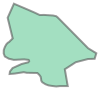

In [12]:
poly['geometry'][0]

### Figure out the bounding box for our area of interest

In [13]:
coords = list(poly["geometry"][0].envelope.exterior.coords)
coords

[(-85.55076, 15.961632),
 (-70.021079, 15.961632),
 (-70.021079, 29.840357),
 (-85.55076, 29.840357),
 (-85.55076, 15.961632)]

### Take a slice of the temperature data only for the area we care about (the bounding box we created)

In [14]:
ds_slice =data.sel(lon=slice(coords[0][0],coords[1][0]), lat=slice(coords[0][1], coords[2][1]))
ds_slice

<xarray.Dataset>
Dimensions:           (time: 13603, lat: 278, lon: 311)
Coordinates:
  * lat               (lat) float32 15.98 16.02 16.08 ... 29.73 29.77 29.83
  * lon               (lon) float32 -85.53 -85.47 -85.43 ... -70.07 -70.03
  * time              (time) datetime64[ns] 1985-01-01T12:00:00 ... 2022-03-3...
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<chunksize=(1, 131, 311), meta=np.ndarray>
    crs               (time) int16 dask.array<chunksize=(31,), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<chunksize=(1, 131, 311), meta=np.ndarray>
Attributes: (12/58)
    Conventions:                CF-1.6, ACDD-1.3
    acknowledgement:            NOAA Coral Reef Watch Program
    cdm_data_type:              Grid
    comment:                    This product is designed to improve on and re...
    contributor_name:           NOAA Coral Reef Watch Program
    contributor_role:           Collecting source data and deriving products;...
    ...                         ...
    time_coverage_duration:     P1D
    time_coverage_end:          19850102T000000Z
    time_coverage_resolution:   P1D
    time_coverage_start:        19850101T000000Z
    title:                      NOAA Coral Reef Watch Daily Global 5km Satell...
    uuid:                       36c339e6-c901-11e7-8a08-38d54702cff0

## Let's take a look at 2005, a year with a lot of coral bleaching in the caribbean

In [15]:
ds_2005 = ds_slice.isel(time=(ds_slice.time.dt.year == 2005))

### With built in xarray functions we can easily visualize the data

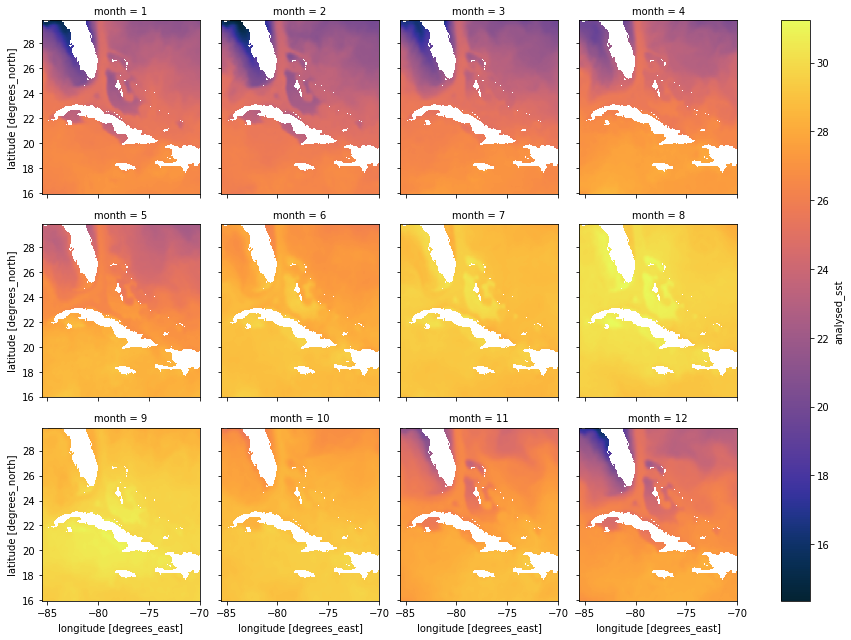

In [23]:
monthly_means = ds_2005.groupby("time.month").mean()
fg = monthly_means.analysed_sst.plot(
    col="month",
    col_wrap=4,
    cmap=cmocean.cm.thermal,
)

### And even see it play over time!

In [25]:
ds_2005.hvplot(
    groupby="time",
    clim=(15, 35),
    widget_type="scrubber",
    widget_location="bottom",
)

Column
    [0] HoloViews(DynamicMap, widget_location='bottom', widget_type='scrubber')
    [1] Row
        [0] HSpacer()
        [1] WidgetBox
            [0] Player(end=364, width=550)
        [2] HSpacer()

## Now let's try to combine temperature data with coral bleaching data

Let's connect to the global coral bleaching database

In [72]:
df_bl = pd.read_csv('bleaching_data.csv')
df_bl['longitude'] = df_bl.Longitude_Degrees.round()
df_bl['latitude'] = df_bl.Latitude_Degrees.round()

df_bl.head()

,Sample_ID,Site_ID,Date_Day,Date_Month,Date_Year,Ecoregion_Name,Latitude_Degrees,Longitude_Degrees,Depth_m,Percent_Bleached,Bleaching_Level,Severity_Code,Number__Bleached_Colonies,bleach_intensity,Distance_to_Shore,Exposure,Turbidity,Cyclone_Frequency,Environmental_ID,ClimSST,Temperature_Kelvin,Temperature_Mean,Temperature_Minimum,Temperature_Maximum,Temperature_Kelvin_Standard_Deviation,Windspeed,SSTA,SSTA_Standard_Deviation,SSTA_Mean,SSTA_Minimum,SSTA_Maximum,SSTA_Frequency,SSTA_Frequency_Standard_Deviation,SSTA_FrequencyMax,SSTA_FrequencyMean,SSTA_DHW,SSTA_DHW_Standard_Deviation,SSTA_DHWMax,SSTA_DHWMean,TSA,TSA_Standard_Deviation,TSA_Minimum,TSA_Maximum,TSA_Mean,TSA_Frequency,TSA_Frequency_Standard_Deviation,TSA_FrequencyMax,TSA_FrequencyMean,TSA_DHW,TSA_DHW_Standard_Deviation,TSA_DHWMax,TSA_DHWMean,TRIAL501,longitude,latitude
0,10318751,21,12.0,10.0,2004.0,45.0,17.168417,-61.818333,8.0,NaN,1.0,NaN,NaN,NaN,40.13,0.0,0.0708,54.009662,48010.0,301.28,302.48,300.22,297.17,303.79,1.22,2.0,0.73,0.77,0.0,-3.080000,2.49,0.0,5.17,27.0,4.0,0.00,2.71,18.89,1.43,0.72,1.22,-4.58,2.02,-1.53,0.0,1.18,5.0,0.0,0.0,0.80,6.69,0.23,T,-62.0,17.0
1,10318751,21,12.0,10.0,2004.0,45.0,17.168417,-61.818333,8.0,NaN,2.0,NaN,NaN,NaN,40.13,0.0,0.0708,54.009662,48010.0,301.28,302.48,300.22,297.17,303.79,1.22,2.0,0.73,0.77,0.0,-3.080000,2.49,0.0,5.17,27.0,4.0,0.00,2.71,18.89,1.43,0.72,1.22,-4.58,2.02,-1.53,0.0,1.18,5.0,0.0,0.0,0.80,6.69,0.23,T,-62.0,17.0
2,10318758,22,22.0,11.0,2003.0,45.0,17.735278,-61.852222,5.0,NaN,1.0,NaN,NaN,NaN,818.90,2.0,0.0758,61.839162,48011.0,299.75,300.79,300.13,296.67,304.38,1.21,5.0,0.00,0.76,0.0,-2.864286,2.80,3.0,4.74,25.0,4.0,1.01,2.49,16.89,1.44,-0.83,1.21,-4.94,2.75,-1.48,0.0,1.00,3.0,0.0,0.0,0.77,4.28,0.26,T,-62.0,18.0
3,10318758,22,22.0,11.0,2003.0,45.0,17.735278,-61.852222,5.0,NaN,2.0,NaN,NaN,NaN,818.90,2.0,0.0758,61.839162,48011.0,299.75,300.79,300.13,296.67,304.38,1.21,5.0,0.00,0.76,0.0,-2.864286,2.80,3.0,4.74,25.0,4.0,1.01,2.49,16.89,1.44,-0.83,1.21,-4.94,2.75,-1.48,0.0,1.00,3.0,0.0,0.0,0.77,4.28,0.26,T,-62.0,18.0
4,10323299,1212,15.0,1.0,1991.0,6.0,23.764000,-76.120000,17.0,NaN,1.0,1.0,NaN,NaN,83.18,0.0,0.0423,51.095733,63369.0,297.15,298.16,299.82,294.26,305.22,2.16,4.0,0.83,1.00,0.0,-3.752222,3.49,6.0,4.88,25.0,7.0,0.00,3.09,19.21,2.68,-4.47,2.16,-8.36,2.58,-2.80,3.0,1.41,6.0,1.0,0.0,1.08,8.60,0.36,T,-76.0,24.0


In [73]:
df_bl[['Date_Year','Bleaching_Level']].groupby('Date_Year').count()

,Bleaching_Level
Date_Year,
1983.0,6
1987.0,30
1988.0,2
1990.0,1
1991.0,2
1992.0,3
1993.0,5
1994.0,3
1995.0,4


In [74]:
gdf = gpd.GeoDataFrame(
    df_bl, geometry=gpd.points_from_xy(df_bl.Longitude_Degrees, df_bl.Latitude_Degrees))
gdf.head(5)

,Sample_ID,Site_ID,Date_Day,Date_Month,Date_Year,Ecoregion_Name,Latitude_Degrees,Longitude_Degrees,Depth_m,Percent_Bleached,Bleaching_Level,Severity_Code,Number__Bleached_Colonies,bleach_intensity,Distance_to_Shore,Exposure,Turbidity,Cyclone_Frequency,Environmental_ID,ClimSST,Temperature_Kelvin,Temperature_Mean,Temperature_Minimum,Temperature_Maximum,Temperature_Kelvin_Standard_Deviation,Windspeed,SSTA,SSTA_Standard_Deviation,SSTA_Mean,SSTA_Minimum,SSTA_Maximum,SSTA_Frequency,SSTA_Frequency_Standard_Deviation,SSTA_FrequencyMax,SSTA_FrequencyMean,SSTA_DHW,SSTA_DHW_Standard_Deviation,SSTA_DHWMax,SSTA_DHWMean,TSA,TSA_Standard_Deviation,TSA_Minimum,TSA_Maximum,TSA_Mean,TSA_Frequency,TSA_Frequency_Standard_Deviation,TSA_FrequencyMax,TSA_FrequencyMean,TSA_DHW,TSA_DHW_Standard_Deviation,TSA_DHWMax,TSA_DHWMean,TRIAL501,longitude,latitude,geometry
0,10318751,21,12.0,10.0,2004.0,45.0,17.168417,-61.818333,8.0,NaN,1.0,NaN,NaN,NaN,40.13,0.0,0.0708,54.009662,48010.0,301.28,302.48,300.22,297.17,303.79,1.22,2.0,0.73,0.77,0.0,-3.080000,2.49,0.0,5.17,27.0,4.0,0.00,2.71,18.89,1.43,0.72,1.22,-4.58,2.02,-1.53,0.0,1.18,5.0,0.0,0.0,0.80,6.69,0.23,T,-62.0,17.0,POINT (-61.81833 17.16842)
1,10318751,21,12.0,10.0,2004.0,45.0,17.168417,-61.818333,8.0,NaN,2.0,NaN,NaN,NaN,40.13,0.0,0.0708,54.009662,48010.0,301.28,302.48,300.22,297.17,303.79,1.22,2.0,0.73,0.77,0.0,-3.080000,2.49,0.0,5.17,27.0,4.0,0.00,2.71,18.89,1.43,0.72,1.22,-4.58,2.02,-1.53,0.0,1.18,5.0,0.0,0.0,0.80,6.69,0.23,T,-62.0,17.0,POINT (-61.81833 17.16842)
2,10318758,22,22.0,11.0,2003.0,45.0,17.735278,-61.852222,5.0,NaN,1.0,NaN,NaN,NaN,818.90,2.0,0.0758,61.839162,48011.0,299.75,300.79,300.13,296.67,304.38,1.21,5.0,0.00,0.76,0.0,-2.864286,2.80,3.0,4.74,25.0,4.0,1.01,2.49,16.89,1.44,-0.83,1.21,-4.94,2.75,-1.48,0.0,1.00,3.0,0.0,0.0,0.77,4.28,0.26,T,-62.0,18.0,POINT (-61.85222 17.73528)
3,10318758,22,22.0,11.0,2003.0,45.0,17.735278,-61.852222,5.0,NaN,2.0,NaN,NaN,NaN,818.90,2.0,0.0758,61.839162,48011.0,299.75,300.79,300.13,296.67,304.38,1.21,5.0,0.00,0.76,0.0,-2.864286,2.80,3.0,4.74,25.0,4.0,1.01,2.49,16.89,1.44,-0.83,1.21,-4.94,2.75,-1.48,0.0,1.00,3.0,0.0,0.0,0.77,4.28,0.26,T,-62.0,18.0,POINT (-61.85222 17.73528)
4,10323299,1212,15.0,1.0,1991.0,6.0,23.764000,-76.120000,17.0,NaN,1.0,1.0,NaN,NaN,83.18,0.0,0.0423,51.095733,63369.0,297.15,298.16,299.82,294.26,305.22,2.16,4.0,0.83,1.00,0.0,-3.752222,3.49,6.0,4.88,25.0,7.0,0.00,3.09,19.21,2.68,-4.47,2.16,-8.36,2.58,-2.80,3.0,1.41,6.0,1.0,0.0,1.08,8.60,0.36,T,-76.0,24.0,POINT (-76.12000 23.76400)


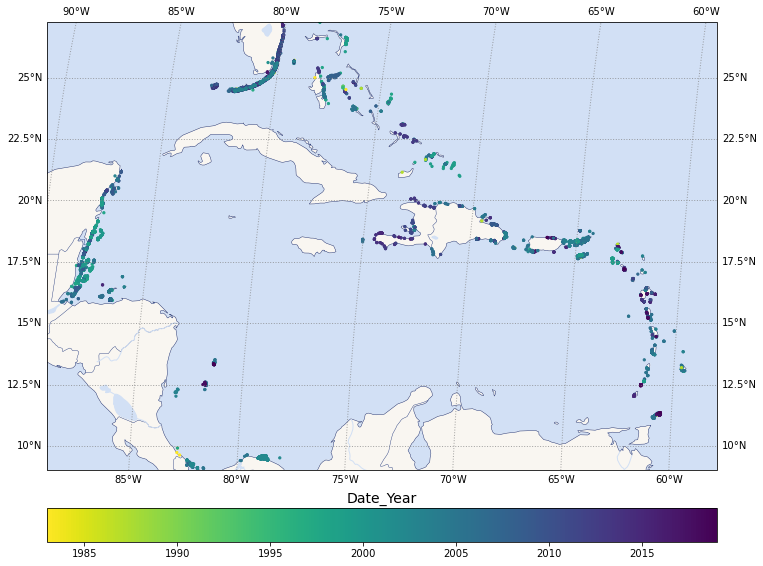

In [67]:
db_plt.plot_points(gdf, col='Date_Year')

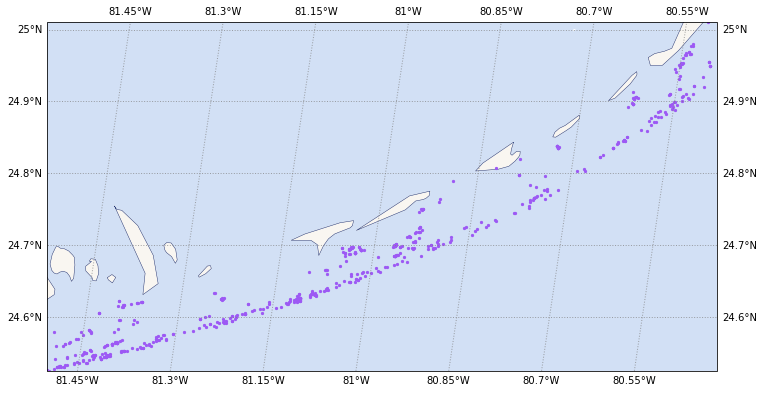

In [76]:
db_plt.plot_points(gdf[(gdf.longitude==-81)&(gdf.latitude==25)])

In [77]:
coords

[(-85.55076, 15.961632),
 (-70.021079, 15.961632),
 (-70.021079, 29.840357),
 (-85.55076, 29.840357),
 (-85.55076, 15.961632)]

In [83]:
ds_keys =data.sel(lon=slice(-82,-81), lat=slice(25, 26))
ds_keys

<xarray.Dataset>
Dimensions:           (time: 13603, lat: 20, lon: 20)
Coordinates:
  * lat               (lat) float32 25.02 25.08 25.12 ... 25.88 25.92 25.98
  * lon               (lon) float32 -81.97 -81.93 -81.88 ... -81.07 -81.03
  * time              (time) datetime64[ns] 1985-01-01T12:00:00 ... 2022-03-3...
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<chunksize=(1, 20, 20), meta=np.ndarray>
    crs               (time) int16 dask.array<chunksize=(31,), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<chunksize=(1, 20, 20), meta=np.ndarray>
Attributes: (12/58)
    Conventions:                CF-1.6, ACDD-1.3
    acknowledgement:            NOAA Coral Reef Watch Program
    cdm_data_type:              Grid
    comment:                    This product is designed to improve on and re...
    contributor_name:           NOAA Coral Reef Watch Program
    contributor_role:           Collecting source data and deriving products;...
    ...                         ...
    time_coverage_duration:     P1D
    time_coverage_end:          19850102T000000Z
    time_coverage_resolution:   P1D
    time_coverage_start:        19850101T000000Z
    title:                      NOAA Coral Reef Watch Daily Global 5km Satell...
    uuid:                       36c339e6-c901-11e7-8a08-38d54702cff0

### We can also turn it into a pandas dataframe that more people are familiar with to do things like groupbys

Let's take a smaller time subset of the xarray

In [16]:
ds_slice =data.sel(lon=slice(-80,-78), lat=slice(20, 22), time=slice('1990-01-01', '2022-01-01'))
ds_slice

<xarray.Dataset>
Dimensions:           (time: 11689, lat: 40, lon: 40)
Coordinates:
  * lat               (lat) float32 20.02 20.08 20.12 ... 21.88 21.92 21.98
  * lon               (lon) float32 -79.97 -79.93 -79.88 ... -78.07 -78.03
  * time              (time) datetime64[ns] 1990-01-01T12:00:00 ... 2022-01-0...
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<chunksize=(1, 40, 40), meta=np.ndarray>
    crs               (time) int16 dask.array<chunksize=(31,), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<chunksize=(1, 40, 40), meta=np.ndarray>
Attributes: (12/58)
    Conventions:                CF-1.6, ACDD-1.3
    acknowledgement:            NOAA Coral Reef Watch Program
    cdm_data_type:              Grid
    comment:                    This product is designed to improve on and re...
    contributor_name:           NOAA Coral Reef Watch Program
    contributor_role:           Collecting source data and deriving products;...
    ...                         ...
    time_coverage_duration:     P1D
    time_coverage_end:          19850102T000000Z
    time_coverage_resolution:   P1D
    time_coverage_start:        19850101T000000Z
    title:                      NOAA Coral Reef Watch Daily Global 5km Satell...
    uuid:                       36c339e6-c901-11e7-8a08-38d54702cff0

In [17]:
%%time
df = ds_slice.to_dataframe().reset_index() ## This can take some time depending on size of slice
df['time'] = pd.to_datetime(df['time'],format='%m/%d/%y %I:%M%p')
df['mnth_yr'] = df.time.dt.to_period('M').astype(str)
df['year'] = df.time.dt.year.astype(str)
df['month'] = df.time.dt.month.astype(int)


KeyboardInterrupt



In [30]:
df.head()

,time,lat,lon,analysed_sst,crs,sea_ice_fraction,mnth_yr,year,month
0,1990-01-01 12:00:00,20.025,-79.974998,26.119999,-32767,0.0,1990-01,1990,1
1,1990-01-01 12:00:00,20.025,-79.925003,26.129999,-32767,0.0,1990-01,1990,1
2,1990-01-01 12:00:00,20.025,-79.875000,26.129999,-32767,0.0,1990-01,1990,1
3,1990-01-01 12:00:00,20.025,-79.824997,26.150000,-32767,0.0,1990-01,1990,1
4,1990-01-01 12:00:00,20.025,-79.775002,26.150000,-32767,0.0,1990-01,1990,1


### This is taking a lot of liberties of grouping this giant area together <br> Will be better when we have exat locations of reefs

In [59]:
df_plot = df.groupby(['mnth_yr', 'year','month']).agg({'analysed_sst': ['mean', 'min', 'max']}).reset_index()
df_plot.columns=['mnth_yr','year','month','mean','min','max']


In [33]:
df_plot

,mnth_yr,year,month,mean,min,max
180,2005-01,2005,1,25.243402,21.830000,26.889999
181,2005-02,2005,2,24.751781,22.090000,26.439999
182,2005-03,2005,3,26.076075,24.039999,28.490000
183,2005-04,2005,4,27.278975,25.500000,28.359999
184,2005-05,2005,5,28.375410,26.299999,30.910000
185,2005-06,2005,6,29.301451,28.420000,30.740000
186,2005-07,2005,7,29.414568,28.420000,31.049999
187,2005-08,2005,8,30.408577,29.429998,31.320000
188,2005-09,2005,9,30.699005,29.279999,31.849998
189,2005-10,2005,10,29.325800,27.250000,30.469999


In [43]:
selection = alt.selection_multi(fields=['year'], bind="legend")
chart = alt.Chart(df_plot).mark_line().encode(
            x=alt.X("month", title="Month", sort="ascending"),
            y=alt.Y('mean', title='Monthly mean temperature',scale=alt.Scale(domain=(22,33))),
            color=alt.Color('year', title="Year",
                            scale=alt.Scale(domain=df_plot["year"].unique(), scheme="paired")),
            opacity=alt.condition(selection, alt.value(1), alt.value(0.2)),
            # tooltip=[alt.Tooltip('mean', title='Mean Temperature')],
            tooltip=['mean', 'year'],
)


line = alt.Chart(pd.DataFrame({'mean': [30.5]})).mark_rule().encode(y='mean', color=alt.value("#FF0000"),strokeWidth=alt.value(3))

alt.layer(chart, line).configure_view(
    stroke='transparent'
).properties(
            title='Monthly average per year',width=500,height=300
        ).configure_axis(
            labelFontSize=15,
            titleFontSize=15
        ).configure_legend(labelFontSize=12, columns=1, labelLimit=500, symbolLimit=100).add_selection(
            selection
        ).add_selection(
            selection
        )

alt.LayerChart(...)

In [60]:
df_plot = df_plot[df_plot.year =='2005']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


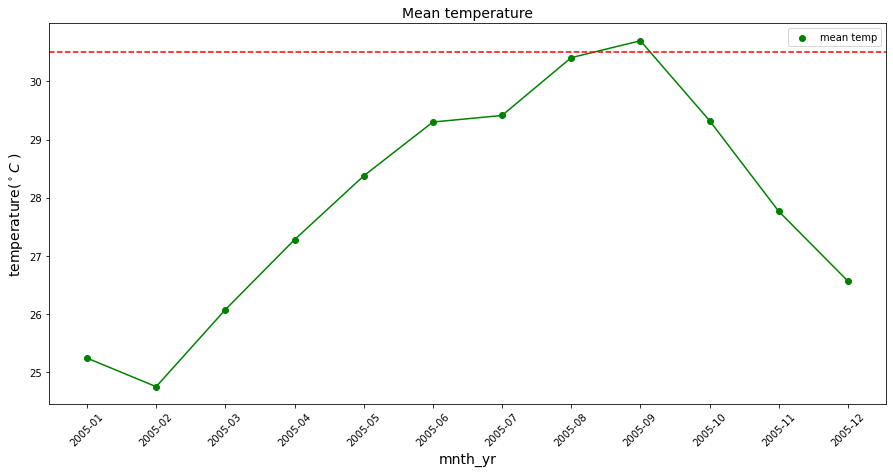

In [61]:
plt.figure(figsize=(15,7))


plt.plot(df_plot['mnth_yr'],df_plot['mean'], 'g')
plt.axhline(y =30.5, color = 'r', linestyle = '--')


plt.legend()
plt.scatter(df_plot['mnth_yr'],df_plot['mean'],c='g',label='mean temp')


plt.xlabel('mnth_yr',size=14)
plt.ylabel('temperature($^\circ C$ )',size=14)
plt.xticks(rotation = 45)
plt.xticks(df_plot['mnth_yr'])
ax=plt.gca()
# ax.axis([0,11,-40,40])
# plt.gca().fill_between(df_plot['time'], 
#                        df_plot['analysed_sst']['max'], df_plot['analysed_sst']['min'], 
#                        facecolor='#9D59F4', 
#                        alpha=0.35)
plt.title('Mean temperature',size=14)
plt.legend(loc=0)

plt.show()


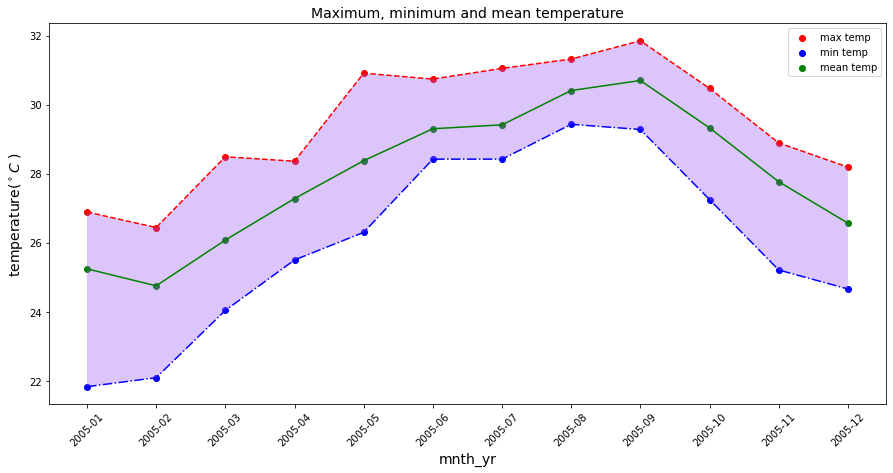

In [63]:
plt.figure(figsize=(15,7))

plt.plot(df_plot['mnth_yr'],df_plot['max'], '--r')
plt.plot(df_plot['mnth_yr'],df_plot['min'], '-.b')
plt.plot(df_plot['mnth_yr'],df_plot['mean'], 'g')
plt.scatter(df_plot['mnth_yr'],df_plot['max'],c='r',label='max temp')
plt.scatter(df_plot['mnth_yr'],df_plot['min'],c='b',label='min temp')
plt.scatter(df_plot['mnth_yr'],df_plot['mean'],c='g',label='mean temp')

plt.xlabel('mnth_yr',size=14)
plt.ylabel('temperature($^\circ C$ )',size=14)
plt.xticks(rotation = 45)
plt.xticks(df_plot['mnth_yr'])
ax=plt.gca()
# ax.axis([0,11,-40,40])
plt.gca().fill_between(df_plot['mnth_yr'], 
                       df_plot['max'], df_plot['min'], 
                       facecolor='#9D59F4', 
                       alpha=0.35)
plt.title('Maximum, minimum and mean temperature',size=14)
plt.legend(loc=0)

plt.show()
